In [1]:
from pathlib import Path
from functools import reduce
import ast
import re
import warnings

import numpy as np
import pandas as pd

from scipy.stats import zscore

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
PROJECT_ROOT = Path.cwd().parent     
DATA_DIR = PROJECT_ROOT / "data"
RAW = DATA_DIR / "raw"
PROCESSED = DATA_DIR / "processed"

df2 = pd.read_csv(RAW / 'efmeqtoysysxvmxh.csv') # shares information (CRSP)
df5 = pd.read_csv(RAW / 'zhrnie4yh2z5tips.csv')

# Stock information

In [3]:
# --- 1. Prepare df2 (detailed CRSP) -------------------------------------
df2 = df2.copy()
df2['date'] = pd.to_datetime(df2['date'])
df2['PRC'] = df2['PRC'].abs()
df2['ME']  = df2['PRC'] * df2['SHROUT']     # Market Equity in USD-thousands
df2 = df2.query("SHRCD in [10,11] and EXCHCD in [1,2,3]")   # Common stocks, main exchanges

# Keep one record per PERMNO×date (largest market cap if duplicates)
df2 = (
    df2.sort_values(['PERMNO','date','ME'], ascending=[True,True,False])
        .drop_duplicates(['PERMNO','date'], keep='first')
)

# --- 2. Prepare df5 (compact CRSP) -------------------------------------
df5 = df5.rename(columns={
    'MthCalDt':'date', 'MthPrc':'Price', 'MthRet':'Ret', 'MthCap':'Cap'
}).copy()
df5['date']  = pd.to_datetime(df5['date'])
df5['Price'] = df5['Price'].abs()

# Keep one record per PERMNO×date (largest market cap if duplicates)
df5 = (
    df5.sort_values(['PERMNO','date','Cap'], ascending=[True,True,False])
        .drop_duplicates(['PERMNO','date'], keep='first')
)

# --- 3. Merge df2 and df5 on PERMNO×date --------------------------------
crsp = pd.merge(
    df2,
    df5[['PERMNO','date','Price','Ret','Cap','HdrCUSIP','SecurityNm','Ticker','PERMCO']],
    on=['PERMNO','date'],
    how='outer',
    validate='one_to_one'   # ensures 1:1 match, raises if still duplicated
)

# --- 4. Coalesce overlapping variables ----------------------------------
crsp['Price'] = crsp['Price'].combine_first(crsp['PRC']).abs()
crsp['Ret']   = pd.to_numeric(crsp['Ret'].combine_first(crsp['RET']), errors='coerce')
crsp['Cap']   = crsp['Cap'].combine_first(crsp['ME'])

# --- 5. Final checks ----------------------------------------------------
assert not crsp.duplicated(['PERMNO','date']).any(), "Duplicate PERMNO×date remain!"
crsp = crsp.sort_values(['PERMNO','date']).reset_index(drop=True)

print(f"{len(crsp):,} total firm-months | {crsp['PERMNO'].nunique():,} unique securities")
print(f"Available stock metrics = {crsp.columns}")

4,725,019 total firm-months | 38,307 unique securities
Available stock metrics = Index(['PERMNO', 'date', 'SHRCD', 'EXCHCD', 'TICKER', 'COMNAM', 'PERMCO_x',
       'NWPERM', 'PRC', 'RET', 'SHROUT', 'ME', 'Price', 'Ret', 'Cap',
       'HdrCUSIP', 'SecurityNm', 'Ticker', 'PERMCO_y'],
      dtype='object')


In [4]:
# --- 6. create matrices (wide panels) in a memory-safe way -------------------------

# Make sure date is datetime and data is sorted once
crsp["date"] = pd.to_datetime(crsp["date"])
crsp = crsp.sort_values(["date", "PERMNO"])

prices_wide  = {}
returns_wide = {}
mktcap_wide  = {}
valid_mask   = {}

years = range(2015, 2025)

for year in years:
    # Slice only this year's data
    temp = crsp.loc[crsp["date"].dt.year == year, ["date", "PERMNO", "Price", "Ret", "Cap"]]

    # If no data for that year, skip
    if temp.empty:
        print(f"Year {year}: no CRSP data")
        continue

    # Pivot only for this year (small matrices)
    prices_y  = temp.pivot(index="date", columns="PERMNO", values="Price")
    returns_y = temp.pivot(index="date", columns="PERMNO", values="Ret")
    mktcap_y  = temp.pivot(index="date", columns="PERMNO", values="Cap")

    # Keep only stocks with > 6 months of data in that year
    mask_y = mktcap_y.notna().sum(axis=0) > 6

    prices_wide[year]   = prices_y.loc[:, mask_y]
    returns_wide[year]  = returns_y.loc[:, mask_y]
    mktcap_wide[year]   = mktcap_y.loc[:, mask_y]
    valid_mask[year]    = mask_y

    print(f"Year {year}: {mask_y.sum()} stocks kept")

prices_panel = pd.concat(prices_wide, names=["Year", "date"])
returns_panel = pd.concat(returns_wide, names=["Year", "date"])
mktcap_panel  = pd.concat(mktcap_wide, names=["Year", "date"])

Year 2015: 7170 stocks kept
Year 2016: 7202 stocks kept
Year 2017: 7245 stocks kept
Year 2018: 7404 stocks kept
Year 2019: 7550 stocks kept
Year 2020: 7599 stocks kept
Year 2021: 8676 stocks kept
Year 2022: 9539 stocks kept
Year 2023: 9370 stocks kept
Year 2024: 9480 stocks kept


In [5]:
# Export market cap at the end of year 2024 for portfolio illustration in 2025 (in notebook 03)
mktcap_2024 = mktcap_wide[2024].to_csv(PROCESSED / "mktcap_2024.csv")

# Firms Locations & Revenues Information

In [6]:
# HQ Locations
df1 = pd.read_csv(RAW / 'elgrayvtzm0d3uru.csv')

# Set index correctly
df1 = df1.set_index("LPERMNO")

# Filter US firms 
US_FIRMS_LOCATIONS = df1[df1["fic"] == "USA"]

# Keep only firms with a city reported
US_FIRMS_LOCATIONS = US_FIRMS_LOCATIONS[US_FIRMS_LOCATIONS['city'].notna()]

# Drop unnecessary columns
columns_to_drop = ["LPERMNO", "fyear", "indfmt", "consol", "popsrc", "datafmt", "costat"]
US_FIRMS_LOCATIONS = US_FIRMS_LOCATIONS.drop(columns=columns_to_drop, errors='ignore')

# Convert datadate to datetime (fix wrong variable reference)
US_FIRMS_LOCATIONS['datadate'] = pd.to_datetime(US_FIRMS_LOCATIONS['datadate'])

# Extract year
US_FIRMS_LOCATIONS['year'] = US_FIRMS_LOCATIONS['datadate'].dt.year

# Drop datadate if you no longer need it
US_FIRMS_LOCATIONS = US_FIRMS_LOCATIONS.drop(columns='datadate')

US_FIRMS_LOCATIONS

,GVKEY,LPERMCO,tic,curcd,fic,city,conml,loc,naics,state,year
LPERMNO,,,,,,,,,,,
10015,1001,6398,AMFD.,USD,USA,Tulsa,A & M Food Services Inc,USA,722.0,OK,1983
10015,1001,6398,AMFD.,USD,USA,Tulsa,A & M Food Services Inc,USA,722.0,OK,1984
10015,1001,6398,AMFD.,USD,USA,Tulsa,A & M Food Services Inc,USA,722.0,OK,1985
10023,1002,22159,AAIC.1,USD,USA,Hunt Valley,AAI Corp,USA,NaN,MD,1972
10031,1003,6672,ANTQ,USD,USA,St. Louis,A.A. Importing Co Inc,USA,442110.0,MO,1983
...,...,...,...,...,...,...,...,...,...,...,...
17324,349530,56274,NXTP,USD,USA,Sunrise,NextPlay Technologies Inc,USA,541810.0,FL,2022
15642,349972,55395,INDP,USD,USA,New York,Indaptus Therapeutics Inc,USA,325414.0,NY,2021
15642,349972,55395,INDP,USD,USA,New York,Indaptus Therapeutics Inc,USA,325414.0,NY,2022


In [7]:
# Revenue segmentation per country 
df3 = pd.read_csv(RAW / 'slxmdlabjc312mui.csv')
print(df3.columns)

/var/folders/xg/fl5l6pt95d7fpp2w76q844vw0000gn/T/ipykernel_2486/848516811.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv(RAW / 'slxmdlabjc312mui.csv')


Index(['stype', 'tic', 'datadate', 'gvkey', 'conm', 'curcds', 'snms', 'soptp1',
       'soptp2', 'geotp', 'intseg', 'revts', 'intseg_dc', 'revts_dc', 'sid',
       'srcdate'],
      dtype='object')


In [8]:
geo = df3[df3['stype'] == 'GEOSEG'] # filter to get geographic segmentation info
domestic_labels = [
    'United States',
    'Domestic',
    'No Foreign Areas Reported'
]

geo['is_domestic'] = geo['snms'].isin(domestic_labels).astype(int)

total_rev = geo.groupby(['gvkey','datadate'])['revts'].sum().reset_index(name='total_rev')

domestic_rev = (geo[geo['is_domestic'] == 1]
                .groupby(['gvkey','datadate'])['revts']
                .sum()
                .reset_index(name='us_rev'))

rev = total_rev.merge(domestic_rev, on=['gvkey','datadate'], how='left')
rev['us_share'] = rev['us_rev'] / rev['total_rev']

rev['domestic_flag'] = (rev['us_share'] >= 0.75).astype(int)
rev['fully_domestic_flag'] = (rev['us_share'] == 1).astype(int)
rev['no_foreign_flag'] = (rev['us_rev'].notnull() & rev['us_rev'] == rev['total_rev']).astype(int)

US_DOMESTIC_FIRMS = rev[rev['domestic_flag'] == 1] # firms that have more than 75% of their revenue in the US
US_DOMESTIC_FIRMS

/var/folders/xg/fl5l6pt95d7fpp2w76q844vw0000gn/T/ipykernel_2486/1024138063.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo['is_domestic'] = geo['snms'].isin(domestic_labels).astype(int)


,gvkey,datadate,total_rev,us_rev,us_share,domestic_flag,fully_domestic_flag,no_foreign_flag
33,1004,1999-05-31,1836.072,1836.072,1.000000,1,1,0
34,1004,2000-05-31,1024.333,1024.333,1.000000,1,1,0
35,1004,2001-05-31,2622.765,2622.765,1.000000,1,1,0
36,1004,2002-05-31,1916.163,1916.163,1.000000,1,1,0
37,1004,2003-05-31,1819.011,1819.011,1.000000,1,1,0
...,...,...,...,...,...,...,...,...
303291,345920,2023-12-31,459.024,359.688,0.783593,1,0,0
303292,345920,2024-12-31,193.293,151.660,0.784612,1,0,0
303296,347007,2024-12-31,14.745,14.214,0.963988,1,0,0
303337,366911,2023-12-31,23354.000,17972.000,0.769547,1,0,0


In [9]:
USA_FIRMS = df1[df1['fic'] == 'USA']
USA_FIRMS = USA_FIRMS[USA_FIRMS['city'].notna()]
USA_FIRMS

,GVKEY,LPERMCO,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,costat,fic,city,conml,loc,naics,state
LPERMNO,,,,,,,,,,,,,,,,,
10015,1001,6398,1983-12-31,1983.0,INDL,C,D,STD,AMFD.,USD,I,USA,Tulsa,A & M Food Services Inc,USA,722.0,OK
10015,1001,6398,1984-12-31,1984.0,INDL,C,D,STD,AMFD.,USD,I,USA,Tulsa,A & M Food Services Inc,USA,722.0,OK
10015,1001,6398,1985-12-31,1985.0,INDL,C,D,STD,AMFD.,USD,I,USA,Tulsa,A & M Food Services Inc,USA,722.0,OK
10023,1002,22159,1972-12-31,1972.0,INDL,C,D,STD,AAIC.1,USD,I,USA,Hunt Valley,AAI Corp,USA,NaN,MD
10031,1003,6672,1983-12-31,1983.0,INDL,C,D,STD,ANTQ,USD,I,USA,St. Louis,A.A. Importing Co Inc,USA,442110.0,MO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17324,349530,56274,2022-02-28,2021.0,INDL,C,D,STD,NXTP,USD,A,USA,Sunrise,NextPlay Technologies Inc,USA,541810.0,FL
15642,349972,55395,2021-12-31,2021.0,INDL,C,D,STD,INDP,USD,A,USA,New York,Indaptus Therapeutics Inc,USA,325414.0,NY
15642,349972,55395,2022-12-31,2022.0,INDL,C,D,STD,INDP,USD,A,USA,New York,Indaptus Therapeutics Inc,USA,325414.0,NY


# Physical Risk Layer
Load the Emergency Events Database (EM-DAT). This flood report is managed by the Centre for Research on the Epidemiology of Disasters in Belgium, which contains all types of global natural disasters from 1900 to the present. Data accessed on 16/11/2025. (retrieved on https://public.emdat.be/data)

In [10]:
df6 = pd.read_excel(RAW / "public_emdat_custom_request_2025-11-16_d2c46b89-0bfa-4495-954c-390d417bf8b7.xlsx")

In [11]:
hazard_map = ['Storm', 'Flood', 'Wildfire', 'Drought'] # physical risk according to the IPCC
CLIMATE_EVENTS = df6[df6['Disaster Type'].isin(hazard_map)]
CLIMATE_EVENTS

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,1900-0003-USA,Yes,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,USA,...,NaN,NaN,NaN,NaN,30000.0,1131126.0,2.652223,NaN,2004-10-18,2023-10-17
1,1903-0002-USA,Yes,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,USA,...,NaN,NaN,NaN,NaN,480000.0,16757429.0,2.864401,NaN,2003-07-01,2025-09-02
2,1903-0003-USA,Yes,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,USA,...,NaN,NaN,NaN,NaN,600.0,20947.0,2.864401,NaN,2003-07-01,2025-09-02
3,1903-0010-USA,Yes,nat-met-sto-tor,Natural,Meteorological,Storm,Tornado,NaN,NaN,USA,...,NaN,NaN,NaN,NaN,1000.0,34911.0,2.864401,NaN,2003-07-01,2025-09-02
4,1906-0004-USA,Yes,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Hurricane 'Florida Keys',USA,...,NaN,NaN,NaN,NaN,4135.0,144358.0,2.864401,NaN,2003-07-01,2025-10-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,2025-0477-USA,No,nat-cli-wil-wil,Natural,Climatological,Wildfire,Wildfire (General),NaN,'Rowena' fire,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-07,2025-07-14
1192,2025-0498-USA,No,nat-hyd-flo-fla,Natural,Hydrological,Flood,Flash flood,NaN,NaN,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-09,2025-07-14
1193,2025-0562-USA,No,nat-hyd-flo-fla,Natural,Hydrological,Flood,Flash flood,NaN,NaN,USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-07-15,2025-07-18
1195,2025-0700-USA,No,nat-cli-wil-wil,Natural,Climatological,Wildfire,Wildfire (General),NaN,"Fires 'Lee', 'Red Canyon', 'Sunset', 'Flat(, '...",USA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-08-20,2025-08-27


In [12]:
# extracte state for each event 

def extract_states(admin_str):
    # Handle missing or empty entries
    if pd.isna(admin_str) or admin_str == '':
        return []
    try:
        units = ast.literal_eval(admin_str)
    except (ValueError, SyntaxError):
        # If parsing fails, treat as no admin info
        return []
    
    states = []
    for u in units:
        # Some dicts have adm1_name (state), others only adm2 (county)
        adm1 = u.get('adm1_name')
        if adm1:
            states.append(adm1)
    
    # Remove duplicates in case a state appears twice
    return list(set(states))

CLIMATE_EVENTS = CLIMATE_EVENTS.copy()  # avoid SettingWithCopyWarning

CLIMATE_EVENTS['state_list'] = CLIMATE_EVENTS['Admin Units'].apply(extract_states)

In [13]:

# -----------------------------------------------------------------------------
# 1. US States + Optional Aliases
# -----------------------------------------------------------------------------
US_STATES = [
    "Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut",
    "Delaware","Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa",
    "Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
    "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada","New Hampshire",
    "New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio",
    "Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota",
    "Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia",
    "Wisconsin","Wyoming"
]

STATE_ALIASES = {
    "Californie": "California",
    # Add more aliases if needed
}

# -----------------------------------------------------------------------------
# 2. Extract states from Admin Units (JSON-like string)
# -----------------------------------------------------------------------------
def extract_states_from_admin_units(admin_str):
    if pd.isna(admin_str) or admin_str == "":
        return []
    try:
        units = ast.literal_eval(admin_str)
    except (ValueError, SyntaxError):
        return []
    
    states = []
    for u in units:
        adm1 = u.get("adm1_name")
        if adm1:
            states.append(adm1)
    return list(set(states))  # unique state names

# -----------------------------------------------------------------------------
# 3. Extract states from Location (fallback)
# -----------------------------------------------------------------------------
def extract_states_from_location(loc):
    if pd.isna(loc) or loc == "":
        return []

    text = loc

    # Replace aliases
    for wrong, correct in STATE_ALIASES.items():
        text = text.replace(wrong, correct)

    text_low = text.lower()

    found_states = []
    for state in US_STATES:
        pattern = r'\b' + re.escape(state.lower()) + r'\b'
        if re.search(pattern, text_low):
            found_states.append(state)

    return list(set(found_states))

# -----------------------------------------------------------------------------
# 4. Apply extraction logic
# -----------------------------------------------------------------------------
CLIMATE_EVENTS = CLIMATE_EVENTS.copy()

# Drop any existing 'state' columns (to avoid duplicates)
if 'state' in CLIMATE_EVENTS.columns:
    CLIMATE_EVENTS = CLIMATE_EVENTS.drop(columns=['state'])

# Admin Units → primary source
CLIMATE_EVENTS['state_list'] = CLIMATE_EVENTS['Admin Units'].apply(extract_states_from_admin_units)

# Identify events with no state info
mask_empty = CLIMATE_EVENTS['state_list'].apply(lambda x: len(x) == 0)

# Fallback to Location column
CLIMATE_EVENTS.loc[mask_empty, 'state_list'] = (
    CLIMATE_EVENTS.loc[mask_empty, 'Location'].apply(extract_states_from_location)
)

# -----------------------------------------------------------------------------
# 5. Expand to one row per state
# -----------------------------------------------------------------------------
CLIMATE_EVENTS = CLIMATE_EVENTS.explode('state_list')

# Rename for clarity
CLIMATE_EVENTS = CLIMATE_EVENTS.rename(columns={'state_list': 'state'})

# Drop rows with no state assigned
CLIMATE_EVENTS = CLIMATE_EVENTS[CLIMATE_EVENTS['state'].notna()].reset_index(drop=True)

CLIMATE_EVENTS.head()

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update,state
0,1900-0003-USA,Yes,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,USA,...,NaN,NaN,NaN,30000.0,1131126.0,2.652223,NaN,2004-10-18,2023-10-17,Texas
1,1903-0002-USA,Yes,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,USA,...,NaN,NaN,NaN,480000.0,16757429.0,2.864401,NaN,2003-07-01,2025-09-02,New Jersey
2,1903-0002-USA,Yes,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,USA,...,NaN,NaN,NaN,480000.0,16757429.0,2.864401,NaN,2003-07-01,2025-09-02,Delaware
3,1903-0003-USA,Yes,nat-hyd-flo-flo,Natural,Hydrological,Flood,Flood (General),NaN,NaN,USA,...,NaN,NaN,NaN,600.0,20947.0,2.864401,NaN,2003-07-01,2025-09-02,Oregon
4,1903-0010-USA,Yes,nat-met-sto-tor,Natural,Meteorological,Storm,Tornado,NaN,NaN,USA,...,NaN,NaN,NaN,1000.0,34911.0,2.864401,NaN,2003-07-01,2025-09-02,Georgia


In [14]:
# create a clean event date
CLIMATE_EVENTS['year'] = CLIMATE_EVENTS['Start Year'].astype(int)
CLIMATE_EVENTS = CLIMATE_EVENTS[(CLIMATE_EVENTS['year'] >= 1900) & (CLIMATE_EVENTS['year'] <= 2024)]

In [15]:
# create severity score per disaster event

import numpy as np

df = CLIMATE_EVENTS.copy()

# Components
df['deaths'] = df['Total Deaths'].fillna(0)
df['damage'] = df["Total Damage ('000 US$)"].fillna(0)
df['affected'] = df['Total Affected'].fillna(0)

# Composite severity score
df['sev'] = (
    zscore(df['deaths']) +
    zscore(np.log1p(df['damage'])) +
    zscore(np.log1p(df['affected']))
)

df['sev'].describe()

count    4.562000e+03
mean     2.492039e-16
std      1.893042e+00
min     -2.742285e+00
25%     -7.472937e-01
50%     -1.508363e-01
75%      1.031079e+00
max      5.124754e+01
Name: sev, dtype: float64

In [16]:
# aggregate to state x year
freq = df.groupby(["state","year","Disaster Type"]).size().reset_index(name='freq')
sev = df.groupby(["state","year","Disaster Type"])['sev'].mean().reset_index(name='sev_mean')

# Build long-term and recent hazard indices
longterm = df[df['year'] <= 2010].groupby(["state","Disaster Type"]).agg(
    freq_longterm=("Disaster Type",'count'),
    sev_longterm=('sev','mean')
).reset_index()

recent = df[df['year'] >= 2011].groupby(["state","Disaster Type"]).agg(
    freq_recent=("Disaster Type",'count'),
    sev_recent=('sev','mean')
).reset_index()

merged = longterm.merge(
    recent,
    on=["state", "Disaster Type"],
    how="outer"
)

merged = merged.fillna(0)

merged['trend'] = (merged['freq_recent'] - merged['freq_longterm']) / (merged['freq_longterm'] + 1)

STATE_SEVERITY = merged
STATE_SEVERITY

,state,Disaster Type,freq_longterm,sev_longterm,freq_recent,sev_recent,trend
0,Alabama,Drought,1.0,-0.422279,3.0,-0.040659,1.000000
1,Alabama,Flood,8.0,-0.898060,4.0,0.196213,-0.444444
2,Alabama,Storm,63.0,-0.145312,59.0,0.476827,-0.062500
3,Alaska,Drought,0.0,0.000000,1.0,0.204700,1.000000
4,Alaska,Flood,3.0,-0.366470,0.0,0.000000,-0.750000
...,...,...,...,...,...,...,...
177,Wisconsin,Wildfire,1.0,7.889562,0.0,0.000000,-0.500000
178,Wyoming,Drought,1.0,-2.742285,4.0,-0.101834,1.500000
179,Wyoming,Flood,3.0,-1.407328,2.0,0.031664,-0.250000
180,Wyoming,Storm,3.0,-2.077682,21.0,0.127382,4.500000


In [17]:
# Construct Physical Risk Score (PRS)

# 1. Standardize the hazard metrics within each disaster type
STATE_SEVERITY = STATE_SEVERITY.copy()

def standardize_group(g):
    std = g.std(ddof=0)
    if std == 0 or np.isnan(std):
        # if no variation (all zeros), treat as neutral
        return pd.Series(0.0, index=g.index)
    return (g - g.mean()) / std

# z-scores by hazard type
for col in ['freq_longterm', 'sev_longterm', 'freq_recent', 'sev_recent', 'trend']:
    STATE_SEVERITY[col + '_z'] = (
        STATE_SEVERITY
        .groupby('Disaster Type')[col]
        .transform(standardize_group)
    )

# 2. Build a long-term and a recent hazard index per state–hazard

STATE_SEVERITY['longterm_index'] = (
    STATE_SEVERITY['freq_longterm_z'] + STATE_SEVERITY['sev_longterm_z']
) / 2.0

STATE_SEVERITY['recent_index'] = (
    STATE_SEVERITY['freq_recent_z'] +
    STATE_SEVERITY['sev_recent_z'] +
    STATE_SEVERITY['trend_z']
) / 3.0

# 3. Aggregate across hazards to get state-level long-term and recent scores
state_scores = (
    STATE_SEVERITY
    .groupby('state')
    .agg(
        longterm_avg=('longterm_index', 'mean'),
        recent_avg=('recent_index', 'mean')
    )
    .reset_index()
)

# 4. Construct the Physical Risk Score PRS_s
state_scores['PRS'] = 0.5 * (
    state_scores['longterm_avg'] + state_scores['recent_avg']
)

# # 5. Optional: keep per-hazard PRS for diagnostics
# hazard_long = (
#     STATE_SEVERITY
#     .pivot_table(
#         index='state',
#         columns='Disaster Type',
#         values='longterm_index',
#         aggfunc='mean'
#     )
# )

# hazard_recent = (
#     STATE_SEVERITY
#     .pivot_table(
#         index='state',
#         columns='Disaster Type',
#         values='recent_index',
#         aggfunc='mean'
#     )
# )

In [18]:
state_scores.sort_values("PRS", ascending=False)

,state,longterm_avg,recent_avg,PRS
43,Texas,0.774707,0.816737,0.795722
25,Missouri,0.617276,0.541656,0.579466
4,California,0.760958,0.330525,0.545741
13,Illinois,0.727849,0.252339,0.490094
24,Mississippi,0.273046,0.643895,0.458471
18,Louisiana,0.053252,0.785685,0.419469
36,Oklahoma,0.114240,0.542922,0.328581
20,Maryland,0.699862,-0.066325,0.316768
3,Arkansas,0.033076,0.473052,0.253064
16,Kansas,0.093400,0.373457,0.233428


In [19]:
HQ = USA_FIRMS.copy()
HQ

,GVKEY,LPERMCO,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,costat,fic,city,conml,loc,naics,state
LPERMNO,,,,,,,,,,,,,,,,,
10015,1001,6398,1983-12-31,1983.0,INDL,C,D,STD,AMFD.,USD,I,USA,Tulsa,A & M Food Services Inc,USA,722.0,OK
10015,1001,6398,1984-12-31,1984.0,INDL,C,D,STD,AMFD.,USD,I,USA,Tulsa,A & M Food Services Inc,USA,722.0,OK
10015,1001,6398,1985-12-31,1985.0,INDL,C,D,STD,AMFD.,USD,I,USA,Tulsa,A & M Food Services Inc,USA,722.0,OK
10023,1002,22159,1972-12-31,1972.0,INDL,C,D,STD,AAIC.1,USD,I,USA,Hunt Valley,AAI Corp,USA,NaN,MD
10031,1003,6672,1983-12-31,1983.0,INDL,C,D,STD,ANTQ,USD,I,USA,St. Louis,A.A. Importing Co Inc,USA,442110.0,MO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17324,349530,56274,2022-02-28,2021.0,INDL,C,D,STD,NXTP,USD,A,USA,Sunrise,NextPlay Technologies Inc,USA,541810.0,FL
15642,349972,55395,2021-12-31,2021.0,INDL,C,D,STD,INDP,USD,A,USA,New York,Indaptus Therapeutics Inc,USA,325414.0,NY
15642,349972,55395,2022-12-31,2022.0,INDL,C,D,STD,INDP,USD,A,USA,New York,Indaptus Therapeutics Inc,USA,325414.0,NY


In [20]:
state_abbrev_to_full = {
    "AL": "Alabama", "AK": "Alaska", "AZ": "Arizona", "AR": "Arkansas",
    "CA": "California", "CO": "Colorado", "CT": "Connecticut",
    "DE": "Delaware", "FL": "Florida", "GA": "Georgia", "HI": "Hawaii",
    "ID": "Idaho", "IL": "Illinois", "IN": "Indiana", "IA": "Iowa",
    "KS": "Kansas", "KY": "Kentucky", "LA": "Louisiana", "ME": "Maine",
    "MD": "Maryland", "MA": "Massachusetts", "MI": "Michigan",
    "MN": "Minnesota", "MS": "Mississippi", "MO": "Missouri",
    "MT": "Montana", "NE": "Nebraska", "NV": "Nevada",
    "NH": "New Hampshire", "NJ": "New Jersey", "NM": "New Mexico",
    "NY": "New York", "NC": "North Carolina", "ND": "North Dakota",
    "OH": "Ohio", "OK": "Oklahoma", "OR": "Oregon",
    "PA": "Pennsylvania", "RI": "Rhode Island", "SC": "South Carolina",
    "SD": "South Dakota", "TN": "Tennessee", "TX": "Texas",
    "UT": "Utah", "VT": "Vermont", "VA": "Virginia",
    "WA": "Washington", "WV": "West Virginia",
    "WI": "Wisconsin", "WY": "Wyoming"
}

HQ['state_full'] = HQ['state'].map(state_abbrev_to_full)

In [21]:
PRS_BY_STATE = state_scores.iloc[:,[True,False,False,True]]
PRS_BY_STATE

,state,PRS
0,Alabama,0.050534
1,Alaska,-0.775317
2,Arizona,-0.250812
3,Arkansas,0.253064
4,California,0.545741
5,Colorado,0.018352
6,Connecticut,-0.311317
7,Delaware,-0.101374
8,District of Columbia,-0.356163
9,Florida,0.043434


In [22]:
# Remove any accidental state, state_x, state_y columns
for col in ["state", "state_x", "state_y"]:
    if col in HQ.columns:
        HQ_FINAL = HQ.drop(columns=col)
        
HQ_FINAL = HQ_FINAL.merge(
    PRS_BY_STATE,
    left_on='state_full',
    right_on='state',
    how='left'
)

In [23]:
# filter to get only firms that have more than 75% of their revenue in the US

HQ_DOMESTIC = HQ_FINAL[HQ_FINAL["GVKEY"].isin(US_DOMESTIC_FIRMS["gvkey"])]
print(len(HQ_DOMESTIC["LPERMCO"].unique()))
HQ_DOMESTIC

8520


,GVKEY,LPERMCO,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,costat,fic,city,conml,loc,naics,state_full,state,PRS
10,1004,20000,1972-05-31,1971.0,INDL,C,D,STD,AIR,USD,A,USA,Wood Dale,AAR Corp,USA,423860.0,Illinois,Illinois,0.490094
11,1004,20000,1973-05-31,1972.0,INDL,C,D,STD,AIR,USD,A,USA,Wood Dale,AAR Corp,USA,423860.0,Illinois,Illinois,0.490094
12,1004,20000,1974-05-31,1973.0,INDL,C,D,STD,AIR,USD,A,USA,Wood Dale,AAR Corp,USA,423860.0,Illinois,Illinois,0.490094
13,1004,20000,1975-05-31,1974.0,INDL,C,D,STD,AIR,USD,A,USA,Wood Dale,AAR Corp,USA,423860.0,Illinois,Illinois,0.490094
14,1004,20000,1976-05-31,1975.0,INDL,C,D,STD,AIR,USD,A,USA,Wood Dale,AAR Corp,USA,423860.0,Illinois,Illinois,0.490094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288617,345920,57591,2024-12-31,2024.0,INDL,C,D,STD,HYFM,USD,A,USA,Shoemakersville,Hydrofarm Holdings Group Inc,USA,333112.0,Pennsylvania,Pennsylvania,0.218236
288623,347007,55364,2021-12-31,2021.0,INDL,C,D,STD,IBRX,USD,A,USA,San Diego,ImmunityBio Inc,USA,325414.0,California,California,0.545741
288624,347007,55364,2022-12-31,2022.0,INDL,C,D,STD,IBRX,USD,A,USA,San Diego,ImmunityBio Inc,USA,325414.0,California,California,0.545741
288625,347007,55364,2023-12-31,2023.0,INDL,C,D,STD,IBRX,USD,A,USA,San Diego,ImmunityBio Inc,USA,325414.0,California,California,0.545741


# Volatility target

In [24]:
realized_vol = {}

for year in range(2016,2025):
    realized_vol[year] = np.sqrt(12) * returns_wide[year].std(skipna=True)
    
# convert to dataframe
realized_vol_df = pd.DataFrame(realized_vol)
realized_vol_df

,2016,2017,2018,2019,2020,2021,2022,2023,2024
PERMNO,,,,,,,,,
10001,0.633452,0.041045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10025,0.555461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10026,0.210272,0.163569,0.172630,0.169339,0.326078,0.229993,0.341333,0.110035,0.266358
10028,0.669328,0.482828,0.236103,1.190743,1.035461,0.417737,0.530567,0.549490,0.359768
10032,0.145408,0.175299,0.229313,0.346385,0.314132,0.224073,0.365825,0.208689,0.338492
...,...,...,...,...,...,...,...,...,...
93428,0.236593,0.183237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93429,0.179924,0.110551,0.325026,0.163311,0.353853,0.143795,0.159084,0.157673,0.204336
93433,0.538486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Map PERMCO (crsp company number) with PERMNO (crsp security number) for future needs
MAP_PERMCO = crsp.copy()
MAP_PERMCO = MAP_PERMCO.iloc[:,[0, 6]]
MAP_PERMCO = MAP_PERMCO[MAP_PERMCO["PERMCO_x"].notna()]
MAP_PERMCO.PERMCO_x = MAP_PERMCO.PERMCO_x.astype(int)
MAP_PERMCO.index = MAP_PERMCO.PERMNO

In [26]:
# compute idiosyncratic volatility via FF5 factors
df1 = pd.read_csv(RAW / 'arck860skzhz7wcy.csv') # Fama-French and Carhart factor datasets (CRSP)
factors = df1.assign(dateff=pd.to_datetime(df1.dateff))
factors = factors[factors["dateff"]>="2015-01-01"]
factors.index = factors["dateff"]
factors.index.name = "date"
factors

,mktrf,smb,hml,rmw,cma,rf,umd,dateff
date,,,,,,,,
2015-01-30,-0.0309,-0.0093,-0.0345,0.0158,-0.0164,0.0000,0.0374,2015-01-30
2015-02-27,0.0614,0.0036,-0.0179,-0.0110,-0.0175,0.0000,-0.0310,2015-02-27
2015-03-31,-0.0109,0.0308,-0.0038,0.0007,-0.0062,0.0000,0.0270,2015-03-31
2015-04-30,0.0060,-0.0301,0.0180,0.0005,-0.0062,0.0000,-0.0727,2015-04-30
2015-05-29,0.0138,0.0082,-0.0111,-0.0176,-0.0083,0.0000,0.0568,2015-05-29
...,...,...,...,...,...,...,...,...
2024-08-30,0.0161,-0.0355,-0.0110,0.0075,0.0082,0.0048,0.0481,2024-08-30
2024-09-30,0.0173,-0.0092,-0.0277,0.0018,-0.0029,0.0040,-0.0062,2024-09-30
2024-10-31,-0.0100,-0.0088,0.0086,-0.0142,0.0098,0.0039,0.0300,2024-10-31


In [27]:
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")

# -----------------------------
# 0. Prepare returns & factors
# -----------------------------

# 1) Fix returns_panel index: drop "Year" level, keep date
returns_fixed = returns_panel.copy()
returns_fixed.index = returns_fixed.index.droplevel(0)   # remove "Year"
returns_fixed.index = pd.to_datetime(returns_fixed.index)
returns_fixed.index.name = "date"

# 2) Fix factors index: use dateff as datetime index
factors_fixed = factors.copy()
factors_fixed.index = pd.to_datetime(factors_fixed["dateff"])
factors_fixed.index.name = "date"

factors_cols = ["mktrf", "smb", "hml", "rmw", "cma"]

# 3) Build R_full: T x N matrix of EXCESS returns
R_full = returns_fixed.sub(factors_fixed["rf"], axis=0)

# 4) Build F_full: T x K matrix of factors
F_full = factors_fixed[factors_cols]

# 5) Align indices (dates) just in case
R_full, F_full = R_full.align(F_full, join="inner", axis=0)

# List of permnos (columns of R_full)
permnos = R_full.columns.to_numpy()


In [56]:
# -----------------------------
# 1. Yearly matrix OLS (FF5)
# -----------------------------

out_rows = []
years = sorted(R_full.index.year.unique())

for year in years:
    # subset to this year
    mask_y = R_full.index.year == year
    R_y = R_full.loc[mask_y]      # shape (Ty, N)
    F_y = F_full.loc[mask_y]      # shape (Ty, K)

    Ty = len(R_y)
    # need at least K+2 months to estimate K+1 parameters
    if Ty < len(factors_cols) + 2:
        continue

    # Design matrix X_y: Ty x (K+1) [constant + factors]
    X_y = np.column_stack([np.ones(Ty), F_y.values])  # Ty x (K+1)

    # Drop rows with NaNs in factors
    mask_rows = ~np.isnan(X_y).any(axis=1)
    X_clean = X_y[mask_rows]
    R_clean = R_y.values[mask_rows]   # Ty_clean x N

    if X_clean.shape[0] < len(factors_cols) + 1:
        # still not enough observations after cleaning → skip this year
        continue

    # Matrix OLS: B_hat = (X'X)^(-1) X'R
    XtX = X_clean.T @ X_clean
    XtX_inv = np.linalg.inv(XtX)
    B_hat = XtX_inv @ X_clean.T @ R_clean   # (K+1) x N

    # Residuals: E_y = R_clean - X_clean B_hat
    R_hat = X_clean @ B_hat                 # Ty_clean x N
    E_y   = R_clean - R_hat                 # Ty_clean x N

    # Monthly idiosyncratic volatility per stock (column-wise std)
    sigma_monthly = np.nanstd(E_y, axis=0, ddof=1)

    # Annualize (monthly → annual)
    sigma_ann = np.sqrt(12) * sigma_monthly

    # Build DataFrame for this year
    df_year = pd.DataFrame({
        "permno": permnos,
        "year": year,
        "sigma_idio_ann": sigma_ann
    }).dropna(subset=["sigma_idio_ann"])

    out_rows.append(df_year)

# -----------------------------
# 2. Final yearly idiosyncratic volatility panel
# -----------------------------

idiosyncratic_vol = pd.concat(out_rows, ignore_index=True)

valid_mask = idiosyncratic_vol.index.unique()
idiosyncratic_vol.index = idiosyncratic_vol.permno

idiosyncratic_vol.to_parquet(PROCESSED / "idiosyncratic_vol.parquet")

# Financial Controls

In [29]:
df3 = pd.read_csv(RAW / 'djf1ybdfutkbzfxr.csv') # Accounting variables for BANKS (Compustat)
df4 = pd.read_csv(RAW / 'vdza9kq1gruji96v.csv') # Accounting variables for INDUSTRY (Compustat)

comp_banks      = df3.assign(datadate=pd.to_datetime(df3.datadate))
comp_inds       = df4.assign(datadate=pd.to_datetime(df4.datadate))
comp_all        = pd.concat([comp_banks, comp_inds], ignore_index=True)
comp_all        = comp_all.drop_duplicates(subset=["GVKEY", "datadate"])

# comp_all = comp_all[["LPERMNO","datadate","fyear","at","ceq","dlc","dltt"]]

# filter to get only stocks that are in the target variable (idiosyncratic vol)
comp_all = comp_all[comp_all["LPERMNO"].isin(valid_mask)]

comp_all = comp_all[comp_all["datadate"].dt.year >= 2015] # ! lag => 2015 explains target vol in 2016

comp_all.columns

Index(['GVKEY', 'LPERMNO', 'LPERMCO', 'indfmt', 'datafmt', 'consol', 'popsrc',
       'curcd', 'curncd', 'fyear', 'datadate', 'tic', 'costat', 'at', 'ceq',
       'ch', 'chech', 'cshi', 'csho', 'dlc', 'dltt', 'dvt', 'ni', 'che',
       'dvpsp_f'],
      dtype='object')

In [30]:
# 1) SIZE CONTROL = LOG(MKTCAP AT END OF YEAR)

mktcap_fixed = mktcap_panel.copy()
mktcap_fixed.index = mktcap_panel.index.droplevel(0)   # remove "Year"
mktcap_fixed.index = pd.to_datetime(returns_fixed.index)
mktcap_fixed.index.name = "date"
# convert to millions
mktcap_fixed = mktcap_fixed.div(1000)

mktcap_monthly = mktcap_fixed
# mktcap_monthly: index = monthly dates, columns = permno
mktcap_monthly.index = pd.to_datetime(mktcap_monthly.index)

# keep only December observations (month == 12)
dec_mask = mktcap_monthly.index.month == 12
mktcap_dec = mktcap_monthly[dec_mask].copy()

# add year
mktcap_dec["year"] = mktcap_dec.index.year

# reshape to long: permno, year, mktcap_dec
mktcap_dec_long = (
    mktcap_dec
    .drop(columns="year")
    .stack()
    .reset_index()
    .rename(columns={"level_1": "permno", 0: "mktcap"})
)
mktcap_dec_long["year"] = mktcap_dec_long["date"].dt.year

# # lag by one year so Dec t-1 explains year t volatility
# mktcap_dec_long["year"] = mktcap_dec_long["year"] + 1

# log size
mktcap_dec_long["log_mktcap"] = np.log(mktcap_dec_long["mktcap"])

# # restrict (target) years to 2016-2024
# mktcap_dec_long = mktcap_dec_long[mktcap_dec_long["year"].isin(range(2016,2025))]
mktcap_dec_long

,date,PERMNO,mktcap,year,log_mktcap
0,2015-12-31,10001,78.26225,2015,4.360065
1,2015-12-31,10025,393.69645,2015,5.975580
2,2015-12-31,10026,2179.04559,2015,7.686642
3,2015-12-31,10028,4.05768,2015,1.400611
4,2015-12-31,10032,1161.99792,2015,7.057896
...,...,...,...,...,...
78878,2024-12-31,25235,17.86950,2024,2.883095
78879,2024-12-31,25236,20.22019,2024,3.006682
78880,2024-12-31,25237,648.85824,2024,6.475214
78881,2024-12-31,25238,98.64640,2024,4.591542


In [31]:
# 2) LT & ST LEVERAGE RATIOS

controls = comp_all.copy()

controls["debt"] = controls["dlc"].fillna(0) + controls["dltt"].fillna(0)

# Avoid division by zero
eps = 1e-6

controls["lev_assets"] = controls["debt"] / (controls["at"] + eps)
controls["lev_equity"] = controls["debt"] / (controls["ceq"] + eps)

controls["total_debt"] = controls["dlc"].fillna(0) + controls["dltt"].fillna(0)
controls["leverage"] = controls["total_debt"] / (controls["at"] + eps)

# 3) SOLVENCY RATIO = COMMON EQUITY / TOTAL ASSETS

controls["equity_ratio"] = controls["ceq"] / (controls["at"] + eps)

# 4) ASSET GROWTH

controls = controls.sort_values(["LPERMNO", "fyear"])
controls["asset_growth"] = (
    controls.groupby("LPERMNO")["at"].pct_change()
)

# 5) PROFITABILITY

controls["ROA"] = controls["ni"] / controls["at"]
controls["ROE"] = controls["ni"] / controls["ceq"]

# 6) Book-to-Market
controls_final = controls.copy()
controls_final = controls_final.rename(columns={"LPERMNO":"PERMNO", "fyear":"year"})
controls_final = controls_final.merge(mktcap_dec_long, on=["PERMNO", "year"], how="left")

controls_final["book-to-market"] = controls_final["ceq"] / controls_final["mktcap"]

# 7) Cash Holdings
controls_final["cash_ratio"] = controls_final["che"] / controls_final["at"]
controls_final

# Clean controls dataframe
financial_controls_list = ["year", "lev_assets", "lev_equity", "total_debt", "leverage", "equity_ratio", "asset_growth",
                           "ROA", "ROE", "book-to-market", "cash_ratio", "log_mktcap"]
controls_final.index = controls_final.PERMNO

financial_controls = controls_final[financial_controls_list]
financial_controls

/var/folders/xg/fl5l6pt95d7fpp2w76q844vw0000gn/T/ipykernel_2486/3639639513.py:24: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  controls.groupby("LPERMNO")["at"].pct_change()


,year,lev_assets,lev_equity,total_debt,leverage,equity_ratio,asset_growth,ROA,ROE,book-to-market,cash_ratio,log_mktcap
PERMNO,,,,,,,,,,,,
10001,2015,0.331450,0.686194,65.524,0.331450,0.483026,NaN,0.023714,0.049095,1.220116,0.013799,4.360065
10001,2016,0.350717,0.744861,69.240,0.350717,0.470850,-0.001340,0.002598,0.005519,0.704081,0.032737,4.882999
10025,2015,0.484833,2.380711,213.426,0.484833,0.203651,NaN,0.065508,0.321669,0.227708,0.045813,5.975580
10025,2016,0.345171,1.196245,135.525,0.345171,0.288546,-0.108072,0.073356,0.254228,0.190812,0.009362,6.386434
10026,2015,0.001977,0.002449,1.469,0.001977,0.807499,NaN,0.094467,0.116987,0.275313,0.179947,7.686642
...,...,...,...,...,...,...,...,...,...,...,...,...
75578,2020,0.566072,2.005298,1205.238,0.566072,0.282288,0.030694,-0.008095,-0.028676,0.890217,0.169599,6.514930
75578,2021,0.534094,1.809416,1255.778,0.534094,0.295175,0.104318,0.072723,0.246372,0.876532,0.146991,6.674288
75578,2022,0.502234,1.631655,1368.606,0.502234,0.307806,0.158983,0.090655,0.294520,1.089070,0.129918,6.646629


In [32]:
# Mapping of PERMNO -> cik for 10ks 
# Read
cik_banks = pd.read_csv(RAW / "egojomdbzzgypygi.csv")
cik_industries = pd.read_csv(RAW / "kfx2djp7p86n2tvz.csv")

# Keep only relevant columns
banks_small = cik_banks[["GVKEY", "LPERMNO", "LPERMCO", "cik", "conm"]]
industries_small = cik_industries[["GVKEY", "LPERMNO", "LPERMCO", "cik", "conm"]]

# Stack them
cik_merged = pd.concat([banks_small, industries_small], ignore_index=True)

# (Optional) drop exact duplicates
cik_merged = cik_merged.drop_duplicates(subset=["GVKEY", "LPERMNO", "LPERMCO", "cik"])

# Remove rows where 'cik' is NaN, then convert
cik_merged = cik_merged.dropna(subset=['cik'])
cik_merged['cik'] = cik_merged['cik'].astype(int)

# Text/NLP Layer

In [33]:
# -------------------------------------------------------------------
# 1) Load all parquet files from the processed NLP folder
# -------------------------------------------------------------------

files = sorted(PROCESSED.glob("batch_*.parquet"))
dfs   = [pd.read_parquet(f) for f in files]
nlp_raw = pd.concat(dfs, ignore_index=True)

# Basic type cleaning
nlp_raw["filing_date"] = pd.to_datetime(nlp_raw["filing_date"])
nlp_raw["year"]        = nlp_raw["year"].astype(int)

nlp_raw

,cik,form,filing_date,year,item_1a_len,chunks_processed,p_det,p_phys,p_trans,p_spec_high
0,1576724,10-K-A,2016-01-04,2016,0,0,NaN,NaN,NaN,NaN
1,718924,10-K,2016-01-04,2016,44810,22,0.997232,0.999732,0.998977,0.852243
2,763950,10-K,2016-01-04,2016,24302,14,0.330949,0.000313,0.000596,0.852784
3,1133798,10-K-A,2016-01-05,2016,0,0,NaN,NaN,NaN,NaN
4,1407190,10-K-A,2016-01-05,2016,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
73794,1483510,10-K,2024-12-31,2024,0,0,NaN,NaN,NaN,NaN
73795,1683252,10-K,2024-12-31,2024,0,0,NaN,NaN,NaN,NaN
73796,1895939,10-K,2024-12-31,2024,0,0,NaN,NaN,NaN,NaN
73797,72633,10-K,2024-12-31,2024,0,0,NaN,NaN,NaN,NaN


In [34]:
# -------------------------------------------------------------------
# 2) Engineer climate-disclosure features at filing level
# -------------------------------------------------------------------

df = nlp_raw.copy()

# 3.1 Coverage / intensity (Volume-based density)
#     Useful metadata: How "dense" is the climate discussion?
eps = 1e-6
df["coverage_raw"] = df["chunks_processed"] / (df["item_1a_len"] / 1000.0 + eps)
df["coverage"] = df["coverage_raw"].clip(lower=0, upper=5)

# 3.2 Transition vs physical share
df["phys_share"]  = df["p_phys"]
df["trans_share"] = df["p_trans"]

# 3.4 Disclosure Quality Score (DQS) - Best Practice Formula
#     Logic: Score = Relevance * (Specificity + Risk_Signal)
#     This ensures that if text is NOT climate-related (low p_det), the score is 0.

# A. The Gatekeeper: Relevance
#    We use p_det directly. 
relevance = df["p_det"].fillna(0.0)

# B. The Multiplier: Specificity
#    How concrete is the language?
specificity = df["p_spec_high"].fillna(0.0)

# C. Risk Signal Strength (Breadth)
#    We take the MAX of phys/trans.
#    If a company screams "Physical Risk" (0.99) but says nothing on Transition (0.0),
#    they have still identified a strong risk signal. We shouldn't penalize them by averaging.
risk_signal_strength = df[["p_phys", "p_trans"]].max(axis=1).fillna(0.0)

# D. Calculate Composite Score
#    Content Quality = 50% Specificity + 50% Risk Signal Strength
content_quality = (0.5 * specificity) + (0.5 * risk_signal_strength)

#    Final DQS = Relevance * Content Quality.
df["DQS"] = relevance * content_quality 

df.DQS.describe()

count    73799.000000
mean         0.451923
std          0.428408
min          0.000000
25%          0.000000
50%          0.458814
75%          0.900741
max          0.989575
Name: DQS, dtype: float64

In [35]:
# -------------------------------------------------------------------
# 4) Aggregate to firm-year level (cik, year)
# -------------------------------------------------------------------

agg_spec = {
    "item_1a_len":       "mean",   # typical size of risk section
    "chunks_processed":  "mean",
    "coverage":          "mean",
    "p_det":             "mean",
    "p_phys":            "mean",
    "p_trans":           "mean",
    "phys_share":        "mean",
    "trans_share":       "mean",
    "p_spec_high":       "mean",
    "DQS":               "mean",
}

nlp_firm_year = (
    df
    .groupby(["cik", "year"], as_index=False)
    .agg(agg_spec)
)

# -------------------------------------------------------------------
# 5) Final feature set for Gradient Boosting
# -------------------------------------------------------------------
# This `nlp_firm_year` table is what we will merge to:
#   - PRS_BY_STATE (physical risk score per HQ state)
#   - idio_yearly (idiosyncratic volatility target)
#   - controls_final (financial controls)

feature_cols = [
    "coverage",
    "p_det",
    "p_phys",
    "p_trans",
    "phys_share",
    "trans_share",
    "p_spec_high",
    "DQS",
    "item_1a_len",
]

X_nlp = nlp_firm_year[["cik", "year"] + feature_cols]

cik_copy = cik_merged.copy()

# Merge to get PERMNOs
X_nlp.cik = X_nlp.cik.astype(int)
X_nlp_final = X_nlp.merge(cik_copy, on="cik", how="left")

# Put PERMNO as index
X_nlp_final = X_nlp_final.dropna(subset=['LPERMNO'])
X_nlp_final.LPERMNO = X_nlp_final.LPERMNO.astype(int)
X_nlp_final

# Restrict to inputs for the Features DF
columns = ["year", "LPERMNO", "DQS"]
DQS_INPUTS = X_nlp_final[columns]
DQS_INPUTS_FINAL = DQS_INPUTS.rename(columns={"LPERMNO":"PERMNO"})
DQS_INPUTS_FINAL.describe()

/var/folders/xg/fl5l6pt95d7fpp2w76q844vw0000gn/T/ipykernel_2486/2616833627.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_nlp.cik = X_nlp.cik.astype(int)


,year,PERMNO,DQS
count,40794.000000,40794.000000,40794.000000
mean,2020.065622,47416.191548,0.623999
std,2.585281,32943.750686,0.367974
min,2016.000000,10001.000000,0.000000
25%,2018.000000,16278.000000,0.297570
50%,2020.000000,25166.000000,0.829398
75%,2022.000000,84084.000000,0.920593
max,2024.000000,93436.000000,0.989575


# Model 1A: ElasticNet on sample A (firms talking about climate)

In [36]:
# Final DF for Physical Risk Score (PRS) filtered to get only firms that have more 
# than 75% of their revenue in the US => HQ_DOMESTIC
# add PERMNO for features dataframe
HQ_DOMESTIC_FINAL = HQ_DOMESTIC.merge(cik_copy, on="LPERMCO", how="left")
HQ_DOMESTIC_FINAL = HQ_DOMESTIC_FINAL.dropna(subset=['LPERMNO'])
HQ_DOMESTIC_FINAL.LPERMNO = HQ_DOMESTIC_FINAL.LPERMNO.astype(int)
# HQ_DOMESTIC_FINAL.index = HQ_DOMESTIC_FINAL.LPERMNO

# FIX 1: Assign the result back to the variable AND specify 'columns='
HQ_DOMESTIC_FINAL = HQ_DOMESTIC_FINAL.rename(columns={"fyear": "year", "LPERMNO":"PERMNO"})

# Restrict to inputs for the Features DF
target_cols = ["year", "PERMNO", "PRS"]

# FIX 2: Use .copy() to avoid SettingWithCopyWarning later
PRS_INPUTS = HQ_DOMESTIC_FINAL[target_cols].copy() 

PRS_INPUTS = PRS_INPUTS.dropna(subset=['year'])

# FIX 3: Refer to 'year', not 'fyear' (since we renamed it), and do it before filtering
PRS_INPUTS['year'] = PRS_INPUTS['year'].astype(int)

# Filter
PRS_INPUTS = PRS_INPUTS[PRS_INPUTS["year"] >= 2016]


PRS_INPUTS

,year,PERMNO,PRS
45,2016,54594,0.490094
46,2017,54594,0.490094
47,2018,54594,0.490094
48,2019,54594,0.490094
49,2020,54594,0.490094
...,...,...,...
142124,2024,20194,0.218236
142125,2021,15533,0.545741
142126,2022,15533,0.545741
142127,2023,15533,0.545741


In [37]:
CONTROLS_INPUTS = financial_controls.copy()
CONTROLS_INPUTS = CONTROLS_INPUTS[CONTROLS_INPUTS["year"] >= 2016]
to_drop = ["lev_assets", "lev_equity", "total_debt"]
CONTROLS_INPUTS = CONTROLS_INPUTS.drop(columns=to_drop)
CONTROLS_INPUTS = CONTROLS_INPUTS.reset_index()
CONTROLS_INPUTS

,PERMNO,year,leverage,equity_ratio,asset_growth,ROA,ROE,book-to-market,cash_ratio,log_mktcap
0,10001,2016,0.350717,0.470850,-0.001340,0.002598,0.005519,0.704081,0.032737,4.882999
1,10025,2016,0.345171,0.288546,-0.108072,0.073356,0.254228,0.190812,0.009362,6.386434
2,10026,2016,0.002024,0.807065,0.064006,0.096112,0.119088,0.255728,0.195058,7.821940
3,10026,2017,0.001434,0.786785,0.097081,0.091295,0.116036,0.240732,0.173051,7.949572
4,10026,2018,0.001156,0.814464,0.074704,0.111153,0.136474,0.279640,0.142194,7.906375
...,...,...,...,...,...,...,...,...,...,...
29271,75578,2020,0.566072,0.282288,0.030694,-0.008095,-0.028676,0.890217,0.169599,6.514930
29272,75578,2021,0.534094,0.295175,0.104318,0.072723,0.246372,0.876532,0.146991,6.674288
29273,75578,2022,0.502234,0.307806,0.158983,0.090655,0.294520,1.089070,0.129918,6.646629
29274,75578,2023,0.611771,0.238645,-0.022920,-0.090910,-0.380945,1.007537,0.117928,6.446762


In [38]:
SIGMA_IDIO_ANN = idiosyncratic_vol.copy()
SIGMA_IDIO_ANN = SIGMA_IDIO_ANN.rename(columns={'permno': 'PERMNO'})
SIGMA_IDIO_ANN = SIGMA_IDIO_ANN[SIGMA_IDIO_ANN["year"]>=2016]
SIGMA_IDIO_ANN

,PERMNO,year,sigma_idio_ann
permno,,,
10001,10001,2016,0.409311
10025,10025,2016,0.469507
10026,10026,2016,0.178008
10028,10028,2016,0.405076
10032,10032,2016,0.074660
...,...,...,...
24802,24802,2024,0.023254
24805,24805,2024,0.354288
24806,24806,2024,0.093558


In [39]:
# 1. Define the list of DataFrames to be merged
dfs = [DQS_INPUTS_FINAL, PRS_INPUTS, CONTROLS_INPUTS, SIGMA_IDIO_ANN]

# 2. Define the common keys for merging
merge_keys = ['PERMNO', 'year']

# 3. Use reduce to iteratively merge all DataFrames on the common keys
DATA_MODEL = reduce(
    lambda left, right: pd.merge(
        left, 
        right, 
        on=merge_keys, 
        how='outer'  # Keeps all rows present in any of the DataFrames
    ), 
    dfs
)

DATA_MODEL = DATA_MODEL[DATA_MODEL["year"]>=2016]

# Check how many infinite values exist in each column
print(np.isinf(DATA_MODEL.select_dtypes(include=np.number)).sum())

# Replace positive and negative infinity with NaN
DATA_MODEL.replace([np.inf, -np.inf], np.nan, inplace=True)

# Write model to parquet for Random Forest & Gradient Boosting 
DATA_MODEL.to_parquet(path = PROCESSED / "FULL_MODEL_INPUTS_OUTPUT.parquet")

# Now this will run cleanly
DATA_MODEL.describe()

year              0
PERMNO            0
DQS               0
PRS               0
leverage          0
equity_ratio      0
asset_growth      0
ROA               0
ROE               1
book-to-market    0
cash_ratio        0
log_mktcap        0
sigma_idio_ann    0
dtype: int64


,year,PERMNO,DQS,PRS,leverage,equity_ratio,asset_growth,ROA,ROE,book-to-market,cash_ratio,log_mktcap,sigma_idio_ann
count,76743.000000,76743.000000,41510.000000,25362.000000,28244.000000,28159.000000,25179.000000,28144.000000,28068.000000,26386.000000,26582.000000,27714.000000,69653.000000
mean,2020.236921,45425.270683,0.624331,0.198161,0.276581,0.374742,0.201745,-0.219367,-1.195622,1.095038,0.293744,6.390284,0.239876
std,2.587456,33508.604699,0.367917,0.329454,0.392731,1.029218,2.233058,1.741871,192.343418,12.015531,0.306019,2.367499,0.372067
min,2016.000000,10001.000000,0.000000,-0.775317,0.000000,-108.221610,-0.993251,-102.316327,-31837.000000,-1176.585366,0.000000,-1.740116,0.000164
25%,2018.000000,16338.500000,0.298296,-0.075550,0.042713,0.200923,-0.070167,-0.227215,-0.338113,0.192326,0.047438,4.771138,0.064765
50%,2020.000000,22181.000000,0.829683,0.109289,0.210200,0.426387,0.033052,-0.000037,0.021780,0.471226,0.152621,6.372791,0.150535
75%,2022.000000,85565.000000,0.920746,0.545741,0.416680,0.674945,0.168117,0.041151,0.136674,0.919993,0.502314,8.011298,0.301050
max,2025.000000,93436.000000,0.989575,0.795722,24.336586,3.232182,247.744243,165.911765,3205.666667,1096.588457,1.000000,15.146637,31.578421


In [40]:
# --- 1.1 Create interaction term ---
data = DATA_MODEL.copy()

# DataFrame for Sample 1A
data_climate_firms = data[data["DQS"] > 0]

# DataFrame for Sample 1B
data_non_climate_firms = data[data["DQS"] == 0]

data_climate_firms["PRSxDQS"] = data_climate_firms["PRS"] * data_climate_firms["DQS"]

# --- 1.2 Define features and target ---
feature_cols = [
    "DQS",
    "PRS",
    "PRSxDQS",
    "leverage",
    "equity_ratio",
    "asset_growth",
    "ROA",
    "ROE",
    "book-to-market",
    "cash_ratio",
    "log_mktcap",
]

target_col = "sigma_idio_ann"

# Drop rows with missing values in any of these columns
model_df = data_climate_firms.dropna(subset=feature_cols + [target_col]).copy()

X = model_df[feature_cols].values
y = model_df[target_col].values

firm_number = len(model_df.PERMNO.unique())
print(f"Total number of firms with climate disclosure in the model (with valid data) : {firm_number}")

model_df

Total number of firms with climate disclosure in the model (with valid data) : 1785


/var/folders/xg/fl5l6pt95d7fpp2w76q844vw0000gn/T/ipykernel_2486/3742725342.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_climate_firms["PRSxDQS"] = data_climate_firms["PRS"] * data_climate_firms["DQS"]


,year,PERMNO,DQS,PRS,leverage,equity_ratio,asset_growth,ROA,ROE,book-to-market,cash_ratio,log_mktcap,sigma_idio_ann,PRSxDQS
0,2016,10001,0.454567,0.490094,0.350717,0.470850,-0.001340,0.002598,0.005519,0.704081,0.032737,4.882999,0.409311,0.222781
2,2016,10025,0.884946,-0.021613,0.345171,0.288546,-0.108072,0.073356,0.254228,0.190812,0.009362,6.386434,0.469507,-0.019126
4,2016,10026,0.717028,-0.021613,0.002024,0.807065,0.064006,0.096112,0.119088,0.255728,0.195058,7.821940,0.178008,-0.015497
5,2017,10026,0.738369,-0.021613,0.001434,0.786785,0.097081,0.091295,0.116036,0.240732,0.173051,7.949572,0.084315,-0.015958
6,2018,10026,0.714495,-0.021613,0.001156,0.814464,0.074704,0.111153,0.136474,0.279640,0.142194,7.906375,0.097474,-0.015442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48898,2016,75573,0.368041,0.043434,0.213899,0.334296,-0.140019,0.095487,0.285637,0.795462,0.137726,7.752854,0.405474,0.015986
48899,2017,75573,0.433257,0.043434,0.285940,0.335284,0.141336,0.028626,0.085377,1.081024,0.098845,7.581263,0.231921,0.018818
48900,2018,75573,0.817259,0.043434,0.249595,0.344794,-0.024830,0.016867,0.048918,1.515228,0.107039,7.246432,0.458462,0.035497
48901,2019,75573,0.857608,0.043434,0.409930,0.297223,0.185696,0.013541,0.045559,1.481862,0.095746,7.290565,0.418747,0.037249


In [41]:
# ---------------------------------------------------------
# 1) Prepare Data & Sort Chronologically
# ---------------------------------------------------------
# CRITICAL: For TimeSeriesSplit, data MUST be sorted by time.
# We reset the index so the splitter can slice it sequentially.
model_df = model_df.sort_values(by=["year", "PERMNO"]).reset_index(drop=True)

# Optional: Separate a final "Holdout" set (e.g., 2023-2024) that is NEVER touched during tuning.
# This simulates the "Live" performance.
holdout_mask = model_df["year"] >= 2023
dev_mask     = model_df["year"] < 2023

X_dev = model_df.loc[dev_mask, feature_cols]
y_dev = model_df.loc[dev_mask, target_col]

X_test = model_df.loc[holdout_mask, feature_cols]
y_test = model_df.loc[holdout_mask, target_col]

# ---------------------------------------------------------
# 2) Define Walk-Forward Splitter
# ---------------------------------------------------------
# n_splits=5 creates 5 expanding windows.
# Fold 1: Train [Start ... T1], Validate [T1 ... T2]
# Fold 2: Train [Start ... T2], Validate [T2 ... T3]
# ...
tscv = TimeSeriesSplit(n_splits=5)

# ---------------------------------------------------------
# 3) Set up ElasticNet + Pipeline
# ---------------------------------------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000))
])

param_grid = {
    "model__alpha": np.logspace(-4, 2, 15),     # 1e-4 to 1e2
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

# ---------------------------------------------------------
# 4) Grid Search with TimeSeriesSplit
# ---------------------------------------------------------
gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,  # <--- HERE is the change: pass the TimeSeriesSplit object
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

# Fit on the Development set (2016-2022)
# The GridSearch will internally walk forward through this period to find the best params.
gcv.fit(X_dev, y_dev)

print("Best params:", gcv.best_params_)
print("Best Walk-Forward MSE:", -gcv.best_score_)

# ---------------------------------------------------------
# 5) Final Reality Check
# ---------------------------------------------------------
# Now apply the best model to the 2023-2024 holdout data
final_model = gcv.best_estimator_
test_score = final_model.score(X_test, y_test) # Returns R^2 by default
print(f"Final Test Score (R^2) on 2023-2024: {test_score:.4f}")

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best params: {'model__alpha': np.float64(0.005179474679231213), 'model__l1_ratio': 0.5}
Best Walk-Forward MSE: 0.1363519677233135
Final Test Score (R^2) on 2023-2024: 0.1834


In [42]:
best_model = gcv.best_estimator_

# Predict on the unseen Test set (2023-2024)
y_pred_test = best_model.predict(X_test)

# R^2 on Test
r2_test = r2_score(y_test, y_pred_test)

# RMSE on Test
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("-" * 30)
print(f"Final Test Set Performance (2023-2024)")
print("-" * 30)
print(f"R^2:  {r2_test:.3f}")
print(f"MSE:  {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

------------------------------
Final Test Set Performance (2023-2024)
------------------------------
R^2:  0.183
MSE:  0.1190
RMSE: 0.3450


In [43]:
# 5) Inspect Coefficients (Feature Importance)

# Retrieve the trained pipeline from the GridSearch result
best_pipeline = gcv.best_estimator_

# Extract the ElasticNet model from the pipeline step named "model"
enet = best_pipeline.named_steps["model"]

# Extract coefficients and intercept
coef = enet.coef_           # array of shape (n_features,)
intercept = enet.intercept_

# Create a DataFrame to view the results
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coef,
    "abs_coef": np.abs(coef) # Helper to gauge magnitude (strength)
})

# Sort by raw coefficient value (Positive at top, Negative at bottom)
coef_df = coef_df.sort_values("coef", ascending=False)

print(f"Intercept: {intercept:.4f}")
print("-" * 30)
print(coef_df)

# --- Bonus: Sparsity Check ---
# ElasticNet (with l1_ratio=0.5) can shrink coefficients to exactly zero.
# Let's see how many features survived.
n_total = len(coef)
n_zero = np.sum(coef == 0)
n_active = n_total - n_zero

print("-" * 30)
print(f"Feature Selection: {n_active} features kept, {n_zero} features removed (set to 0).")

Intercept: 0.3195
------------------------------
           feature      coef  abs_coef
9       cash_ratio  0.062910  0.062910
5     asset_growth  0.026099  0.026099
1              PRS  0.007671  0.007671
3         leverage  0.006379  0.006379
2          PRSxDQS  0.005881  0.005881
8   book-to-market  0.003662  0.003662
0              DQS -0.000000  0.000000
7              ROE -0.000000  0.000000
4     equity_ratio -0.020375  0.020375
6              ROA -0.027584  0.027584
10      log_mktcap -0.096025  0.096025
------------------------------
Feature Selection: 9 features kept, 2 features removed (set to 0).


In [44]:
results = {
    "best_params": gcv.best_params_,
    "val_r2": r2_test,
    "val_rmse": rmse_test,
    "coef_df": coef_df,
    "intercept": intercept,
}

results 

{'best_params': {'model__alpha': np.float64(0.005179474679231213),
  'model__l1_ratio': 0.5},
 'val_r2': 0.18340619513268697,
 'val_rmse': np.float64(0.3450342349008464),
 'coef_df':            feature      coef  abs_coef
 9       cash_ratio  0.062910  0.062910
 5     asset_growth  0.026099  0.026099
 1              PRS  0.007671  0.007671
 3         leverage  0.006379  0.006379
 2          PRSxDQS  0.005881  0.005881
 8   book-to-market  0.003662  0.003662
 0              DQS -0.000000  0.000000
 7              ROE -0.000000  0.000000
 4     equity_ratio -0.020375  0.020375
 6              ROA -0.027584  0.027584
 10      log_mktcap -0.096025  0.096025,
 'intercept': np.float64(0.3194739358985034)}

# Model 1B: ElasticNet on sample B (firms without climate disclosure)

In [45]:
# --- 1.2 Define features and target ---
feature_cols = [
    "PRS",
    "leverage",
    "equity_ratio",
    "asset_growth",
    "ROA",
    "ROE",
    "book-to-market",
    "cash_ratio",
    "log_mktcap",
]

target_col = "sigma_idio_ann"

# Drop rows with missing values in any of these columns
non_climate_model_df = data_non_climate_firms.dropna(subset=feature_cols + [target_col]).copy()

X = non_climate_model_df[feature_cols].values
y = non_climate_model_df[target_col].values

firm_number = len(non_climate_model_df.PERMNO.unique())
print(f"Total number of firms without climate disclosure in the model (with valid data) : {firm_number}")

non_climate_model_df.describe()

Total number of firms without climate disclosure in the model (with valid data) : 336


,year,PERMNO,DQS,PRS,leverage,equity_ratio,asset_growth,ROA,ROE,book-to-market,cash_ratio,log_mktcap,sigma_idio_ann
count,1011.000000,1011.000000,1011.0,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,2020.211672,26378.270030,0.0,0.207403,0.264907,0.434554,0.166226,-0.115519,0.585712,0.312761,0.287698,6.075215,0.373989
std,2.609333,17922.507026,0.0,0.327404,0.277924,0.472252,1.278815,1.518985,8.379248,8.702655,0.303004,2.221182,0.358777
min,2016.000000,10645.000000,0.0,-0.359804,0.000000,-5.824437,-0.889476,-31.349626,-33.011727,-273.936750,0.000094,0.577315,0.022305
25%,2018.000000,14929.000000,0.0,-0.075550,0.037413,0.232621,-0.070495,-0.173602,-0.264134,0.179854,0.046267,4.356293,0.171193
50%,2020.000000,18075.000000,0.0,0.142773,0.185829,0.467763,0.025331,0.004464,0.033467,0.473035,0.141609,6.045551,0.285035
75%,2023.000000,31691.000000,0.0,0.545741,0.413057,0.727351,0.155926,0.052415,0.144972,0.879990,0.489961,7.490023,0.464975
max,2024.000000,75573.000000,0.0,0.795722,2.415787,0.999999,31.161174,26.633962,166.736842,9.916052,1.000000,12.290463,3.939129


In [46]:
# ---------------------------------------------------------
# 1) Prepare Data & Sort Chronologically
# ---------------------------------------------------------
# CRITICAL: For TimeSeriesSplit, data MUST be sorted by time.
# We reset the index so the splitter can slice it sequentially.
non_climate_model_df = non_climate_model_df.sort_values(by=["year", "PERMNO"]).reset_index(drop=True)

# Optional: Separate a final "Holdout" set (e.g., 2023-2024) that is NEVER touched during tuning.
# This simulates the "Live" performance.
holdout_mask = non_climate_model_df["year"] >= 2023
dev_mask     = non_climate_model_df["year"] < 2023

X_dev = non_climate_model_df.loc[dev_mask, feature_cols]
y_dev = non_climate_model_df.loc[dev_mask, target_col]

X_test = non_climate_model_df.loc[holdout_mask, feature_cols]
y_test = non_climate_model_df.loc[holdout_mask, target_col]

# ---------------------------------------------------------
# 2) Define Walk-Forward Splitter
# ---------------------------------------------------------
# n_splits=5 creates 5 expanding windows.
# Fold 1: Train [Start ... T1], Validate [T1 ... T2]
# Fold 2: Train [Start ... T2], Validate [T2 ... T3]
# ...
tscv = TimeSeriesSplit(n_splits=5)

# ---------------------------------------------------------
# 3) Set up ElasticNet + Pipeline
# ---------------------------------------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000))
])

param_grid = {
    "model__alpha": np.logspace(-4, 2, 15),     # 1e-4 to 1e2
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

# ---------------------------------------------------------
# 4) Grid Search with TimeSeriesSplit
# ---------------------------------------------------------
gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,  # <--- HERE is the change: pass the TimeSeriesSplit object
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

# Fit on the Development set (2016-2022)
# The GridSearch will internally walk forward through this period to find the best params.
gcv.fit(X_dev, y_dev)

print("Best params:", gcv.best_params_)
print("Best Walk-Forward MSE:", -gcv.best_score_)

# ---------------------------------------------------------
# 5) Final Reality Check
# ---------------------------------------------------------
# Now apply the best model to the 2023-2024 holdout data
final_model = gcv.best_estimator_
test_score = final_model.score(X_test, y_test) # Returns R^2 by default
print(f"Final Test Score (R^2) on 2023-2024: {test_score:.4f}")

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best params: {'model__alpha': np.float64(0.2682695795279725), 'model__l1_ratio': 0.1}
Best Walk-Forward MSE: 0.1170108206633694
Final Test Score (R^2) on 2023-2024: 0.1471


In [47]:
best_model = gcv.best_estimator_

# Predict on the unseen Test set (2023-2024)
y_pred_test = best_model.predict(X_test)

# R^2 on Test
r2_test = r2_score(y_test, y_pred_test)

# RMSE on Test
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("-" * 30)
print(f"Final Test Set Performance (2023-2024)")
print("-" * 30)
print(f"R^2:  {r2_test:.3f}")
print(f"MSE:  {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

------------------------------
Final Test Set Performance (2023-2024)
------------------------------
R^2:  0.147
MSE:  0.1072
RMSE: 0.3274


In [48]:
# 5) Inspect Coefficients (Feature Importance)

# Retrieve the trained pipeline from the GridSearch result
best_pipeline = gcv.best_estimator_

# Extract the ElasticNet model from the pipeline step named "model"
enet = best_pipeline.named_steps["model"]

# Extract coefficients and intercept
coef = enet.coef_           # array of shape (n_features,)
intercept = enet.intercept_

# Create a DataFrame to view the results
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coef,
    "abs_coef": np.abs(coef) # Helper to gauge magnitude (strength)
})

# Sort by raw coefficient value (Positive at top, Negative at bottom)
coef_df = coef_df.sort_values("coef", ascending=False)

print(f"Intercept: {intercept:.4f}")
print("-" * 30)
print(coef_df)

# --- Bonus: Sparsity Check ---
# ElasticNet (with l1_ratio=0.5) can shrink coefficients to exactly zero.
# Let's see how many features survived.
n_total = len(coef)
n_zero = np.sum(coef == 0)
n_active = n_total - n_zero

print("-" * 30)
print(f"Feature Selection: {n_active} features kept, {n_zero} features removed (set to 0).")

Intercept: 0.3701
------------------------------
          feature      coef  abs_coef
3    asset_growth  0.071845  0.071845
7      cash_ratio  0.070849  0.070849
0             PRS  0.009929  0.009929
1        leverage  0.000000  0.000000
2    equity_ratio -0.000000  0.000000
5             ROE  0.000000  0.000000
6  book-to-market -0.000000  0.000000
4             ROA -0.022067  0.022067
8      log_mktcap -0.051024  0.051024
------------------------------
Feature Selection: 5 features kept, 4 features removed (set to 0).


In [49]:
results = {
    "best_params": gcv.best_params_,
    "val_r2": r2_test,
    "val_rmse": rmse_test,
    "coef_df": coef_df,
    "intercept": intercept,
}

results 

{'best_params': {'model__alpha': np.float64(0.2682695795279725),
  'model__l1_ratio': 0.1},
 'val_r2': 0.14713324623977164,
 'val_rmse': np.float64(0.3274189056475526),
 'coef_df':           feature      coef  abs_coef
 3    asset_growth  0.071845  0.071845
 7      cash_ratio  0.070849  0.070849
 0             PRS  0.009929  0.009929
 1        leverage  0.000000  0.000000
 2    equity_ratio -0.000000  0.000000
 5             ROE  0.000000  0.000000
 6  book-to-market -0.000000  0.000000
 4             ROA -0.022067  0.022067
 8      log_mktcap -0.051024  0.051024,
 'intercept': np.float64(0.3701099687913007)}

# Model 1C: ElasticNet on sample C (all firms, with a dummy variable for climate disclosure)

In [50]:
# --- 1.1 Create interaction term ---
data_c = DATA_MODEL.copy()

# create a dummy to tell if firm mentions climate or not (0: no mention, 1: mentions)
data_c["climate_mentioned"] = (data_c["DQS"] > 0).astype(int)


data_c["PRSxDQS"] = data_c["PRS"] * data_c["DQS"]

# --- 1.2 Define features and target ---
feature_cols = [
    "DQS",
    "PRS",
    "PRSxDQS",
    "climate_mentioned",
    "leverage",
    "equity_ratio",
    "asset_growth",
    "ROA",
    "ROE",
    "book-to-market",
    "cash_ratio",
    "log_mktcap",
]

target_col = "sigma_idio_ann"

# Drop rows with missing values in any of these columns
model_df_c = data_c.dropna(subset=feature_cols + [target_col]).copy()

X = model_df_c[feature_cols].values
y = model_df_c[target_col].values

firm_number = len(model_df_c.PERMNO.unique())
print(f"Total number of firms in the model with and without climate disclosure (with valid data) : {firm_number}")

#dummy_1 = model_df_c["climate_mentioned"] == 1
#count_of_true = dummy_1.sum()
#print(count_of_true)

model_df_c

Total number of firms in the model with and without climate disclosure (with valid data) : 1856


,year,PERMNO,DQS,PRS,leverage,equity_ratio,asset_growth,ROA,ROE,book-to-market,cash_ratio,log_mktcap,sigma_idio_ann,climate_mentioned,PRSxDQS
0,2016,10001,0.454567,0.490094,0.350717,0.470850,-0.001340,0.002598,0.005519,0.704081,0.032737,4.882999,0.409311,1,0.222781
2,2016,10025,0.884946,-0.021613,0.345171,0.288546,-0.108072,0.073356,0.254228,0.190812,0.009362,6.386434,0.469507,1,-0.019126
4,2016,10026,0.717028,-0.021613,0.002024,0.807065,0.064006,0.096112,0.119088,0.255728,0.195058,7.821940,0.178008,1,-0.015497
5,2017,10026,0.738369,-0.021613,0.001434,0.786785,0.097081,0.091295,0.116036,0.240732,0.173051,7.949572,0.084315,1,-0.015958
6,2018,10026,0.714495,-0.021613,0.001156,0.814464,0.074704,0.111153,0.136474,0.279640,0.142194,7.906375,0.097474,1,-0.015442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48902,2020,75573,0.000000,0.043434,0.308204,0.338251,-0.239776,-0.057395,-0.169681,1.217668,0.131162,7.342089,0.374074,0,0.000000
48903,2021,75573,0.000000,0.043434,0.268243,0.295581,-0.124685,-0.042754,-0.144645,0.755509,0.105653,7.551372,0.258950,0,0.000000
48904,2022,75573,0.000000,0.043434,0.280067,0.310195,-0.147174,0.040010,0.128982,0.669483,0.097132,7.561319,0.247922,0,0.000000
48905,2023,75573,0.522779,0.043434,0.318065,0.283325,-0.063389,0.035769,0.126249,0.529126,0.100875,7.640504,0.179914,1,0.022706


In [51]:
# ---------------------------------------------------------
# 1) Prepare Data & Sort Chronologically
# ---------------------------------------------------------
# CRITICAL: For TimeSeriesSplit, data MUST be sorted by time.
# We reset the index so the splitter can slice it sequentially.
model_df_c = model_df_c.sort_values(by=["year", "PERMNO"]).reset_index(drop=True)

# Optional: Separate a final "Holdout" set (e.g., 2023-2024) that is NEVER touched during tuning.
# This simulates the "Live" performance.
holdout_mask = model_df_c["year"] >= 2023
dev_mask     = model_df_c["year"] < 2023

X_dev = model_df_c.loc[dev_mask, feature_cols]
y_dev = model_df_c.loc[dev_mask, target_col]

X_test = model_df_c.loc[holdout_mask, feature_cols]
y_test = model_df_c.loc[holdout_mask, target_col]

# ---------------------------------------------------------
# 2) Define Walk-Forward Splitter
# ---------------------------------------------------------
# n_splits=5 creates 5 expanding windows.
# Fold 1: Train [Start ... T1], Validate [T1 ... T2]
# Fold 2: Train [Start ... T2], Validate [T2 ... T3]
# ...
tscv = TimeSeriesSplit(n_splits=5)

# ---------------------------------------------------------
# 3) Set up ElasticNet + Pipeline
# ---------------------------------------------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNet(max_iter=10000))
])

param_grid = {
    "model__alpha": np.logspace(-4, 2, 15),     # 1e-4 to 1e2
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
}

# ---------------------------------------------------------
# 4) Grid Search with TimeSeriesSplit
# ---------------------------------------------------------
gcv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=tscv,  # <--- HERE is the change: pass the TimeSeriesSplit object
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

# Fit on the Development set (2016-2022)
# The GridSearch will internally walk forward through this period to find the best params.
gcv.fit(X_dev, y_dev)

print("Best params:", gcv.best_params_)
print("Best Walk-Forward MSE:", -gcv.best_score_)

# ---------------------------------------------------------
# 5) Final Reality Check
# ---------------------------------------------------------
# Now apply the best model to the 2023-2024 holdout data
final_model = gcv.best_estimator_
test_score = final_model.score(X_test, y_test) # Returns R^2 by default
print(f"Final Test Score (R^2) on 2023-2024: {test_score:.4f}")

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best params: {'model__alpha': np.float64(0.005179474679231213), 'model__l1_ratio': 0.9}
Best Walk-Forward MSE: 0.13474451556058267
Final Test Score (R^2) on 2023-2024: 0.1768


In [52]:
best_model = gcv.best_estimator_

# Predict on the unseen Test set (2023-2024)
y_pred_test = best_model.predict(X_test)

# R^2 on Test
r2_test = r2_score(y_test, y_pred_test)

# RMSE on Test
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("-" * 30)
print(f"Final Test Set Performance (2023-2024)")
print("-" * 30)
print(f"R^2:  {r2_test:.3f}")
print(f"MSE:  {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

------------------------------
Final Test Set Performance (2023-2024)
------------------------------
R^2:  0.177
MSE:  0.1183
RMSE: 0.3440


In [53]:
# 5) Inspect Coefficients (Feature Importance)

# Retrieve the trained pipeline from the GridSearch result
best_pipeline = gcv.best_estimator_

# Extract the ElasticNet model from the pipeline step named "model"
enet = best_pipeline.named_steps["model"]

# Extract coefficients and intercept
coef = enet.coef_           # array of shape (n_features,)
intercept = enet.intercept_

# Create a DataFrame to view the results
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coef,
    "abs_coef": np.abs(coef) # Helper to gauge magnitude (strength)
})

# Sort by raw coefficient value (Positive at top, Negative at bottom)
coef_df = coef_df.sort_values("coef", ascending=False)

print(f"Intercept: {intercept:.4f}")
print("-" * 30)
print(coef_df)

# --- Bonus: Sparsity Check ---
# ElasticNet (with l1_ratio=0.5) can shrink coefficients to exactly zero.
# Let's see how many features survived.
n_total = len(coef)
n_zero = np.sum(coef == 0)
n_active = n_total - n_zero

print("-" * 30)
print(f"Feature Selection: {n_active} features kept, {n_zero} features removed (set to 0).")

Intercept: 0.3240
------------------------------
              feature      coef  abs_coef
10         cash_ratio  0.067125  0.067125
6        asset_growth  0.031755  0.031755
1                 PRS  0.012190  0.012190
4            leverage  0.006125  0.006125
0                 DQS  0.000000  0.000000
2             PRSxDQS  0.000000  0.000000
3   climate_mentioned  0.000000  0.000000
8                 ROE -0.000000  0.000000
9      book-to-market  0.000000  0.000000
5        equity_ratio -0.017465  0.017465
7                 ROA -0.024208  0.024208
11         log_mktcap -0.095420  0.095420
------------------------------
Feature Selection: 7 features kept, 5 features removed (set to 0).


In [54]:
results = {
    "best_params": gcv.best_params_,
    "val_r2": r2_test,
    "val_rmse": rmse_test,
    "coef_df": coef_df,
    "intercept": intercept,
}

results 

{'best_params': {'model__alpha': np.float64(0.005179474679231213),
  'model__l1_ratio': 0.9},
 'val_r2': 0.1768066135348404,
 'val_rmse': np.float64(0.34402021723173826),
 'coef_df':               feature      coef  abs_coef
 10         cash_ratio  0.067125  0.067125
 6        asset_growth  0.031755  0.031755
 1                 PRS  0.012190  0.012190
 4            leverage  0.006125  0.006125
 0                 DQS  0.000000  0.000000
 2             PRSxDQS  0.000000  0.000000
 3   climate_mentioned  0.000000  0.000000
 8                 ROE -0.000000  0.000000
 9      book-to-market  0.000000  0.000000
 5        equity_ratio -0.017465  0.017465
 7                 ROA -0.024208  0.024208
 11         log_mktcap -0.095420  0.095420,
 'intercept': np.float64(0.3239866589930636)}

# Presentation Plots

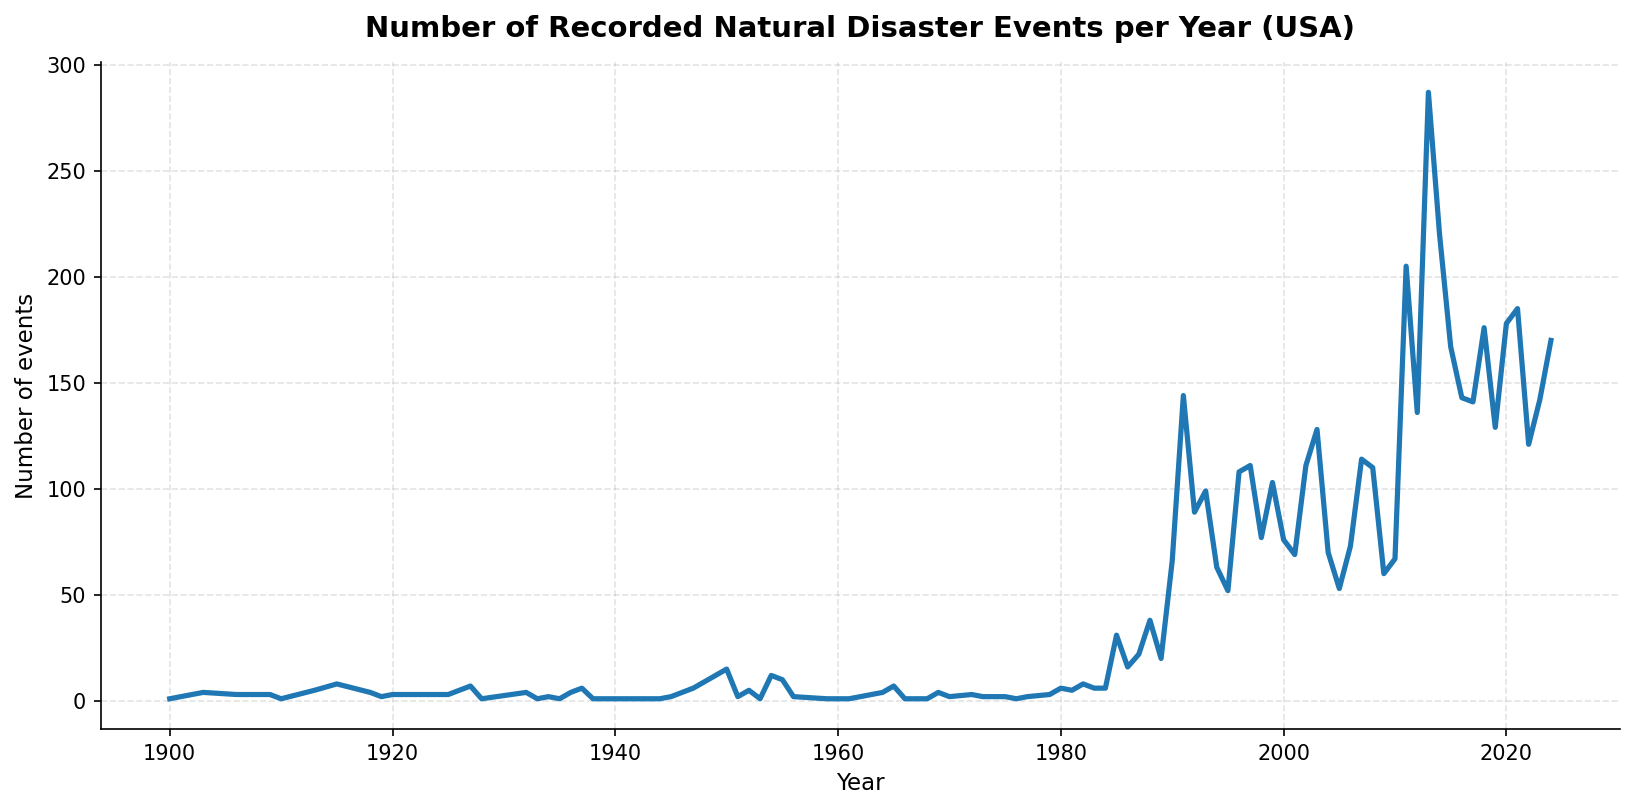

(   year  n_events
 0  1900         1
 1  1903         4
 2  1906         3
 3  1909         3
 4  1910         1,
     year  n_events
 87  2020       178
 88  2021       185
 89  2022       121
 90  2023       142
 91  2024       170)

In [55]:
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 1) Copy the dataframe
# ------------------------------------------------------------
df = CLIMATE_EVENTS.copy()

# ------------------------------------------------------------
# 2) Extract year from DisNo (e.g. "1900-0003-USA" → 1900)
# ------------------------------------------------------------
df["year"] = (
    df["DisNo."]
    .astype(str)
    .str.extract(r"^(\d{4})")[0]
    .astype(float)
)

df = df.dropna(subset=["year"])
df["year"] = df["year"].astype(int)

# ------------------------------------------------------------
# 3) Count number of disaster events per year
# ------------------------------------------------------------
events_per_year = (
    df.groupby("year")
      .size()
      .rename("n_events")
      .reset_index()
      .sort_values("year")
)

# ------------------------------------------------------------
# 4) Plot with a premium, presentation-ready look
# ------------------------------------------------------------
plt.figure(figsize=(11, 5.5), dpi=150)

plt.plot(
    events_per_year["year"],
    events_per_year["n_events"],
    linewidth=2.5
)

plt.title(
    "Number of Recorded Natural Disaster Events per Year (USA)",
    fontsize=14,
    fontweight="bold",
    pad=12
)
plt.xlabel("Year", fontsize=11)
plt.ylabel("Number of events", fontsize=11)

ax = plt.gca()
ax.grid(True, linestyle="--", linewidth=0.8, alpha=0.35)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# Optional: inspect the aggregated data
events_per_year.head(), events_per_year.tail()